In [9]:
from HOX_evolution import *
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import lorenz
import networkx as nx
import copy
import scipy 
import matplotlib.pyplot as plt
#from treelib import Node, Tree
from dask.distributed import Client

print(nx.__version__)
print(scipy.__version__)

2.5
1.6.2


In [6]:
rpy.verbosity(0)

0

In [20]:
def test_genome_as_reservoir(adjacency_matrix, data, prediction_length, train_to, test_to):
    
    input_weights = np.zeros((adjacency_matrix.shape[0]))
    if len(input_weights) < 100:
        input_weights[0:int(len(input_weights)/2)] = 1
    else:
        input_weights[0:50] = 1
    input_weights = input_weights[:,np.newaxis]
    
    node_biases = np.zeros(adjacency_matrix.shape[0])
    node_biases[0] = 1
    node_biases = node_biases[:,np.newaxis]
    
    reservoir = Reservoir(W = adjacency_matrix, Win = input_weights, bias = node_biases)
    readout = Ridge(ridge = 1e-7)
    model = reservoir >> readout 


    training_data_input = data[:train_to,:]
    training_data_desired_output = data[prediction_length:train_to + prediction_length, : ]

    test_data_input = data[train_to:test_to]
    test_data_desired_output = data[train_to + prediction_length: test_to + prediction_length]

    model.fit(training_data_input, training_data_desired_output)

    prediction = model.run(test_data_input)

    performance = np.linalg.norm(prediction - test_data_desired_output, ord = 2)

    return performance, prediction, test_data_desired_output




In [18]:
def draw_n_save_graph(graph, generation, prediction_length, ranking, best, y_hat, y):
    largest_subgraph = sorted(nx.connected_components(graph), key = len, reverse = True)
    largest_subgraph = graph.subgraph(largest_subgraph[0])
    
    
    fig = plt.figure(figsize = (80,40))
    ax = fig.add_subplot(1, 2, 1)
    nx.draw_kamada_kawai(largest_subgraph, node_size = 10)

    
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    y_hat = predictions[best_index][0]
    y = predictions[best_index][1]
    ax.plot(y_hat[:,0], y_hat[:,1], y_hat[:,2])
    ax.plot(y[:,0], y[:,1], y[:,2])
    fig.savefig("Generation_" + str(generation) +" PredictionLength_ " + str(prediction_length) + " Ranking_" + str(ranking) + " Fitness_" + str(best) + ".jpg")
    plt.close("all")

# Reserach note 1
Setting the evolution to target large prediction steps seems to lead to a too flat landscape because the networks fail their predictions. I'll try a seascape type approach instead by moving the prediction step depending on the networks performance going above a treshold

In [21]:

with Client(n_workers = 60) as client:
    data = lorenz(2000, h=0.01)
    #data  = data[:,np.newaxis]
    data = 2 * (data - data.min()) / (data.max() - data.min()) - 1

    train_to = 1000
    prediction_lengths = np.arange(1,100)
    test_to = 1500

    goalpoast_treshold = 2
    goalpoast = 0

    initial_genome = [[0,1,0.1],[1,2,0.2],[2,3, 0.3],[3,4, 0.4],[4,2, 0.5],[4,5, 0.6],[5,6, 0.7]]



    population_size = 64
    genome_population = [copy.deepcopy(initial_genome) for i in range(population_size)]

    n_generations = 10000

    generation_scores = []

    for generation in range(n_generations):
        prediction_length = prediction_lengths[goalpoast]
        print("GENERATION: ", generation)
        mutated_generation = []

        for genome in genome_population:
            mutated_genome = copy.deepcopy(genome)
            for i in range(1):
                mutated_genome = mutate_genome_with_hox(mutated_genome)
            mutated_generation.append(mutated_genome)

        small_worldness_scores = []
        graph_sizes = []
        genome_depths = []
        predictions = []

        for mutated_genome in mutated_generation:
            connectivity_matrix = transcribe_hierarchical_genome(mutated_genome)
            #plt.imshow(connectivity_matrix)
            #plt.show()
            graph = nx.from_numpy_matrix(connectivity_matrix)

            largest_subgraph = sorted(nx.connected_components(graph), key = len, reverse = True)
            largest_subgraph = graph.subgraph(largest_subgraph[0])

            graph_sizes.append(largest_subgraph.number_of_nodes())
            genome_depths.append(compute_genome_depth(mutated_genome))
            #adjacency_matrix = nx.adjacency_matrix(largest_subgraph)
            #adjacency_matrix = nx.to_numpy_array(adjacency_matrix)

            future_omega, y_hat, y = test_genome_as_reservoir(connectivity_matrix, data, prediction_length, train_to, test_to)


            small_worldness_scores.append(future_omega)
            predictions.append([y_hat, y])


        k = 0
        for i, small_worldness_score in enumerate(small_worldness_scores):
            abs_omega = small_worldness_score + (1 - 1/graph_sizes[i]) #no abs for lattice
            small_worldness_scores[i] = abs_omega  
            print(k, " omega ", abs_omega, " genome depth: ", genome_depths[i], "Size: ", graph_sizes[i])
            print("    Fitness: ", small_worldness_scores[i])
            k+=1


        small_worldness_scores = np.array(small_worldness_scores)
        #small_worldness_scores = np.abs(small_worldness_scores)
        #print("Scores ", small_worldness_scores)
        small_worldness_scores[small_worldness_scores == -np.inf] = 10

        generation_scores.append(copy.deepcopy(small_worldness_scores))
        genome_population = []

        goalpoast_moved = False
        for ranking, i in enumerate([14,10,8,7,6,5,4,3,2,1,1,1,1]):

            best_index = np.nanargmin(small_worldness_scores)
            best = small_worldness_scores[best_index]

            if best < goalpoast_treshold and goalpoast < len(prediction_lengths) and goalpoast_moved == False:
                goalpoast += 1
                goalpoast_moved = True


            print("Organism index: ", best_index, "Fitness: ", best)
            
            if ranking == 0:
                connectivity_matrix = transcribe_hierarchical_genome(mutated_generation[best_index])
                connectivity_matrix = connectivity_matrix != 0
                graph = nx.from_numpy_matrix(connectivity_matrix)
                
                largest_subgraph = sorted(nx.connected_components(graph), key = len, reverse = True)
                largest_subgraph = graph.subgraph(largest_subgraph[0])
                
                #adjacency_matrix = nx.adjacency_matrix(largest_subgraph)
                y_hat = predictions[best_index][0]
                y = predictions[best_index][1]
                
                client.submit(draw_n_save_graph, largest_subgraph, generation, prediction_length, ranking, best, y_hat, y)
            genome_population.extend([copy.deepcopy(mutated_generation[best_index]) for k in range(i)])

            small_worldness_scores[best_index] = 1000

GENERATION:  0
Remove Node
Hox remove
Mutate Connection
Add Node
Remove Node
Add Node
Hox remove
Hox copy
Mutate Connection
Mutated Weight
 Hox Shuffle
[5, 6, 0.7]
Hox remove
Remove Node
Remove Node
Add Node
Mutated Weight
Hox remove
Add connection
Hox copy
Mutated Weight
Mutate Connection
Hox copy
Mutate Connection
Mutate Connection
Hox remove
Mutate Connection
Add connection
Mutated Weight
Mutate Connection
Hox copy
Mutated Weight
Hox group
Remove Node
Hox copy
Remove Node
Mutate Connection
Mutated Weight
Mutated Weight
Add connection
Hox group
Add connection
Add connection
Hox group
Add connection
Hox remove
Add Node
Mutated Weight
Hox group
Add Node
Add connection
Hox group
Mutated Weight
Hox group
Remove Node
 Hox Shuffle
[4, 2, 0.5]
Hox remove
Add Node
Mutated Weight
Hox group
Mutate Connection
Remove Node
Mutated Weight
Remove Node
 Hox Shuffle
[5, 6, 0.7]


ValueError: Dimension mismatch in Reservoir-493: Win input dimension is 1 but input dimension is 3.

In [ ]:
def f ():
    return 1,2

x,y = f()
x

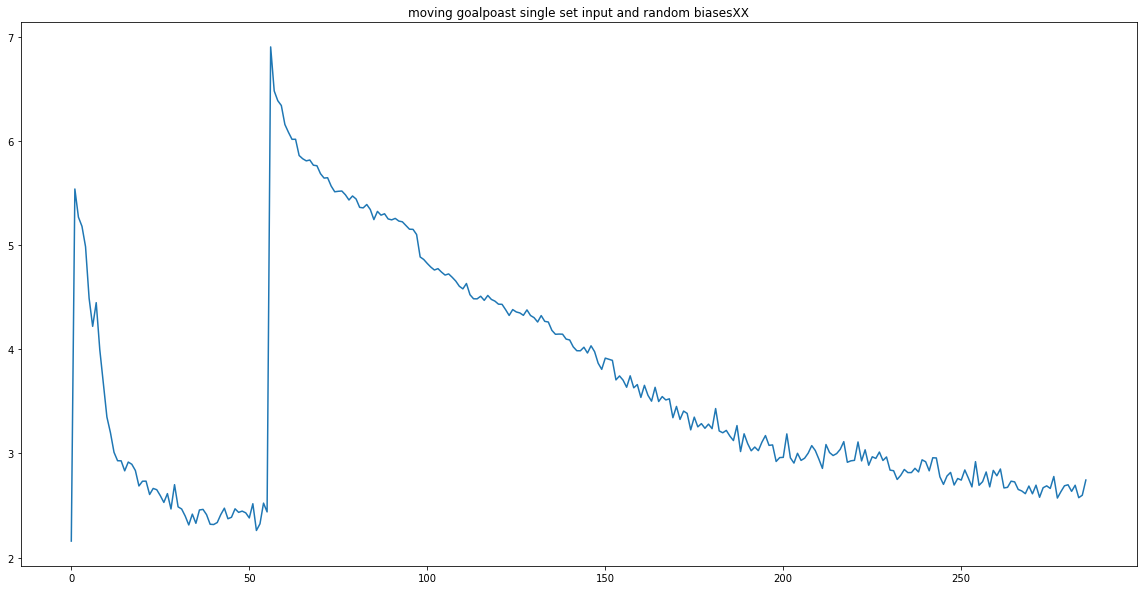

In [5]:
mean_generation_scores_hox = np.nanmean(np.abs(np.array(generation_scores[1:])), axis = 1)
fig = plt.figure(figsize = (20,10))
plt.title("moving goalpoast single set input and random biasesXX")
plt.plot(mean_generation_scores_hox)
fig.savefig("constant_input_weights_XX.jpg")


In [ ]:
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import logistic_map
rpy.set_seed(9)

size = 100
predict_t_ahead = 2
train_up_to = 100
test_to = train_up_to + 100


weights =  np.random.normal(0,1, size = (size,size))
weights = weights / (weights*size)
print(np.amax(np.linalg.eigvals(weights)))

reservoir = Reservoir(W = weights)
readout = Ridge(ridge = 1e-7)

esn_model = reservoir >> readout

X = logistic_map(2000)
#X  = X[:,np.newaxis]
X = 2 * (X - X.min()) / (X.max() - X.min()) - 1
#X = np.repeat(X[:], 10, axis = 1)

esn_model.fit(X[:train_up_to], X[predict_t_ahead:train_up_to + predict_t_ahead])

#X = np.random.normal(0,1, size = (2000,))
#X  = X[:,np.newaxis]
#X = 2 * (X - X.min()) / (X.max() - X.min()) - 1

#reservoir.reset()
prediction = esn_model.run(X[train_up_to:test_to + predict_t_ahead])


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=affd06f4-455d-4db0-beca-a63ea1debc03' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>